# Implementing Neural Network

# 1- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers.normalization import BatchNormalization
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# testing GPU on colab
import tensorflow as tf
tf.test.gpu_device_name()

''

# 2-Loading Data

In [5]:
data=pd.read_csv('train_data_clean.csv')
#data=data.rename(columns={'Unnamed: 0':'random_columns'}) # a trick to tackle random index values
data.shape

(10000, 3)

In [6]:
data.head(2)

,news,category,clean
0,Top 5 Reasons Why 'Divergent' Star Kate Winsle...,e,top 5 reason diverg star kate winslet deserv s...
1,Vessyl Bottle Tracks Your Drink And Its Health...,t,vessyl bottl track drink health benefitsgadget...


In [7]:
data.isnull().sum()

news        0
category    0
clean       0
dtype: int64

In [8]:
#loading test feature and label data saved from previous notebooks
feature_test=pd.read_csv('test_data.csv')
label_test=pd.read_csv('test_label.csv')

In [9]:
print(feature_test.shape)
print(label_test.shape)

(84484, 2)
(84484, 1)


In [10]:
#Function for category id
data['category_id'] = data['category'].factorize()[0]
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

# 3- Preparing Data for Model

In [11]:
y=data['category']
X=data['clean']

In [12]:
print(X.shape)
print(y.shape)

(10000,)
(10000,)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7500,)
(7500,)
(2500,)
(2500,)


### 3.1.Convert words to matrix

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200 # roughly thinking size of a headline news
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train.values)

In [16]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15470 unique tokens.


In [17]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X_train.values)

In [18]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,20.0,182.0,211.0,233.0,1742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,700.0,45.0,1266.0,14.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38.0,1551.0,67.0,3606.0,500.0,94.0,234.0,2315.0,160.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
3,274.0,32.0,45.0,431.0,38.0,1743.0,807.0,2773.0,72.0,808.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3607.0,131.0,64.0,72.0,329.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#pad_sequence:To keep all vectors of same length, I will use pad_sequence
X_pd_sq_train = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [20]:
print('Shape of data tensor:', X_pd_sq_train.shape)

Shape of data tensor: (7500, 200)


In [21]:
pd.DataFrame(X_pd_sq_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,182,211,233,1742
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,700,45,1266,14,42
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,1551,67,3606,500,94,234,2315,160,63
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,32,45,431,38,1743,807,2773,72,808
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3607,131,64,72,329,124


In [22]:
X_test_token = tokenizer.texts_to_sequences(X_test)
pd.DataFrame(X_test_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,41.0,977.0,1242.0,94.0,14.0,3951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1162.0,148.0,313.0,291.0,2182.0,79.0,72.0,4560.0,711.0,NaN,NaN,NaN,NaN,NaN,NaN
2,113.0,2819.0,45.0,563.0,521.0,496.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62.0,9.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,20.0,39.0,2519.0,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
X_pd_sq_test = pad_sequences(X_test_token,maxlen=MAX_SEQUENCE_LENGTH)
pd.DataFrame(X_pd_sq_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,977,1242,94,14,3951
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1162,148,313,291,2182,79,72,4560,711
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113,2819,45,563,521,496,63
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,9,84
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,20,39,2519,398


In [24]:
print(X_pd_sq_train.shape)
print(X_pd_sq_test.shape)

(7500, 200)
(2500, 200)


### 3.2.Target variable encoding

In [25]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

In [26]:
y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [27]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(7500, 4)
(2500, 4)


Now both target variables are also ready for model

In [28]:
y_train[:10]

4901    b
4375    b
6698    e
9805    e
1101    e
9537    e
7655    t
5235    e
5165    b
118     t
Name: category, dtype: object

In [29]:
y_train_ohe[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [30]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['e', 'b', 't', 'm']

In [31]:
len(unique_y_labels)

4

# 4- LSTM model
- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 4 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function

In [32]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 200 #same as X_pd_sq.shape[1]
EMBEDDING_DIM = 100
uniq_y_label=len(unique_y_labels)

In [33]:
X_pd_sq_train.shape[1]

200

In [34]:
uniq_y_label

4

### 4.1.Model Architecture

In [35]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pd_sq_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(uniq_y_label, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 100)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 100)          400       
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 581,204
Trainable params: 581,004
Non-trainable params: 200
________________________________________________

### 4.2.Taking care of Imbalanced class issue

In [37]:
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights = {i : class_weights[i] for i in range(4)}

In [38]:
# hyperparameters
batch_size = 64
epochs = 15

### 4.3.Training Model

In [39]:
%%time
history = model.fit(X_pd_sq_train, y_train_ohe, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,class_weight=class_weights,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/15
106/106 [==============================] - 54s 510ms/step - loss: 0.9800 - accuracy: 0.5867 - val_loss: 1.3034 - val_accuracy: 0.5013
Epoch 2/15
106/106 [==============================] - 54s 512ms/step - loss: 0.3310 - accuracy: 0.8871 - val_loss: 1.1287 - val_accuracy: 0.6947
Epoch 3/15
106/106 [==============================] - 54s 509ms/step - loss: 0.1409 - accuracy: 0.9526 - val_loss: 0.8081 - val_accuracy: 0.7893
Epoch 4/15
106/106 [==============================] - 55s 515ms/step - loss: 0.0769 - accuracy: 0.9744 - val_loss: 0.5293 - val_accuracy: 0.8133
Epoch 5/15
106/106 [==============================] - 54s 514ms/step - loss: 0.0519 - accuracy: 0.9809 - val_loss: 0.5512 - val_accuracy: 0.8213
Epoch 6/15
106/106 [==============================] - 57s 539ms/step - loss: 0.0383 - accuracy: 0.9886 - val_loss: 0.7262 - val_accuracy: 0.8320
Epoch 7/15
106/106 [==============================] - 56s 526ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.8371 - val_ac

### 4.4.Saving Tokenizer

In [40]:
import pickle

# saving
with open('tokenizer_nn.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer_nn.pickle', 'rb') as handle:
    tokenizer_nn = pickle.load(handle)

### 4.5.Saving model

In [41]:
from keras.models import load_model

model.save('nn_model.h5') 
model_nn = load_model('nn_model.h5')

### 5-Model Evaluation

### 5.1.Accuracy and loss scores

In [42]:
accr = model_nn.evaluate(X_pd_sq_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

79/79 [==============================] - 5s 61ms/step - loss: 0.7353 - accuracy: 0.8292
Test set
  Loss: 0.735
  Accuracy: 0.829


In [43]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

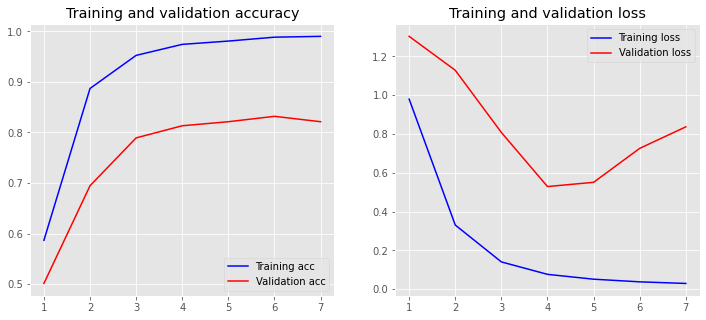

In [44]:
plot_history(history)

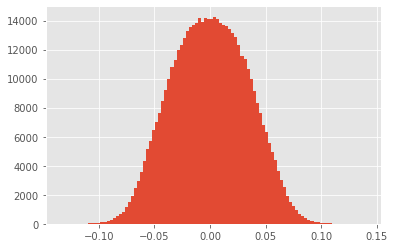

In [45]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [46]:
#model.weights

### 5.2.probabilities ditribution

In [47]:
pred_class = model_nn.predict(X_pd_sq_test)
pred_class[:5]

array([[3.94818169e-04, 9.99387026e-01, 2.88558349e-05, 1.89256258e-04],
       [3.32426976e-06, 9.99962926e-01, 2.10471935e-05, 1.26296945e-05],
       [9.98441160e-01, 9.14941847e-05, 1.73016670e-04, 1.29431789e-03],
       [9.94583905e-01, 4.61553922e-04, 4.91899031e-04, 4.46263468e-03],
       [9.95460689e-01, 3.27606285e-05, 3.61703895e-03, 8.89543328e-04]],
      dtype=float32)

This is probabilities of our output. We need to convert to crisp classes.

### 5.3.Class_prediction

In [49]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model_nn.predict_classes(X_pd_sq_test, verbose=0)
yhat_classes[:10]

array([1, 1, 0, 0, 0, 0, 3, 0, 1, 2])

In [50]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(pred_class,axis=1)

In [51]:
# predicted classes
y_pred_class[:10]

array([1, 1, 0, 0, 0, 0, 3, 0, 1, 2])

In [52]:
# in form of class type
y_test_class[:10]

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 2])

In [53]:
# in matrix form
y_test_ohe[:10]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [54]:
# real data
y_test[:10]

6252    e
4684    e
1731    b
4742    b
4521    b
6340    b
576     b
5202    b
6363    e
439     m
Name: category, dtype: object

- For our model, encoding scheme has been changed 
- b=0 ,e=1 , m=2 ,t=3
- This will help in decoding back our values

### 5.4.CLassification Report

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       702
           1       0.91      0.90      0.90       893
           2       0.72      0.73      0.73       295
           3       0.81      0.81      0.81       610

    accuracy                           0.83      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.83      0.83      0.83      2500



b=0 ,e=1 , m=2 ,t=3

### 5.5.Confusion Matrix

In [56]:
cm=confusion_matrix(y_test_class,y_pred_class)
cm

array([[563,  38,  44,  57],
       [ 28, 802,  25,  38],
       [ 37,  19, 215,  24],
       [ 76,  27,  14, 493]])

In [57]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

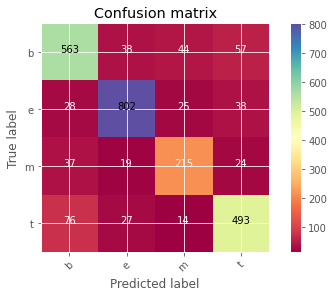

In [58]:
plot_confusion_matrix(cm, classes=['b', 'e','m','t'])

b=0 ,e=1 , m=2 ,t=3

### 6-API Idea

- key: text
- output1: class prediction
- output2: probability of each class (higher is better)

In [59]:
texts=["YouTube updates to include crowd-funding options"]

In [60]:
text_token = tokenizer.texts_to_sequences(texts)
text_features=pad_sequences(text_token,maxlen=MAX_SEQUENCE_LENGTH)

In [61]:
score = model_nn.predict(text_features)
score

array([[0.22913286, 0.55610895, 0.19522157, 0.01953661]], dtype=float32)

In [62]:
pred_class = np.argmax(score,axis=1)
pred_class

array([1])

In [63]:
prob=score.max(axis=1)
prob

array([0.55610895], dtype=float32)

b=0 ,e=1 , m=2 ,t=3

In [64]:
result=texts
result=pd.DataFrame(result,columns=["text"])
result["news-type"]=pred_class
result["news-type"]=result['news-type'].map({0 : "b", 1 : "e", 2 :"m", 3:"t"})
result["probability"]=prob

In [65]:
result

,text,news-type,probability
0,YouTube updates to include crowd-funding options,e,0.556109


In [66]:
json_table = result.to_json(orient='records')  
json_table

'[{"text":"YouTube updates to include crowd-funding options","news-type":"e","probability":0.5561089516}]'